<a href="https://colab.research.google.com/github/BrunoGomesCoelho/mosquito-networking/blob/master/notebooks_tcc/1.7-BrunoGomesCoelho_Colab_fixes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab console code
"""
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}setInterval(ClickConnect,60000)
"""

'\nfunction ClickConnect(){\nconsole.log("Working"); \ndocument.querySelector("colab-toolbar-button#connect").click() \n}setInterval(ClickConnect,60000)\n'

## Check tensorflow version

In [2]:
!python3 -m pip install --upgrade tensorflow -q

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import tensorflow as tf
from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.0.0


In [4]:
tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [5]:
# Start logging time
import time
start_time = time.time()

In [6]:
COLAB_IDX = 1
TEMPERATURE = "t02"
FORMAT = "repeat"

In [7]:
SCALE = True
TESTING = True
COLAB = False

if COLAB:
    BASE_DIR = "/content/drive/My Drive/IC/mosquito-networking/"
else:
    BASE_DIR = "../"

In [8]:
if COLAB:
    from google.colab import drive
    drive.flush_and_unmount()
    drive.mount('/content/drive', force_remount=True)

In [9]:
if COLAB:
    import sys
    sys.path.append("/content/drive/My Drive/IC/mosquito-networking/")

In [10]:
if COLAB:
    !python3 -m pip install -qr "/content/drive/My Drive/IC/mosquito-networking/drive_requirements.txt"

In [11]:
if not COLAB:
    # OPTIONAL: Load the "autoreload" extension so that code can change
    %load_ext autoreload
    # OPTIONAL: always reload modules so that as you change code in src, it gets loaded
    %autoreload 2

In [12]:
import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Experiment params

In [13]:
# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'epochs': 2 if TESTING else 100}

# load data

In [14]:
# Load scaler
#scaler = joblib.load("../data/interim/scaler.pkl")
if SCALE:
    scaler = joblib.load(BASE_DIR + 
                         f"data/interim/scaler_{FORMAT}_{TEMPERATURE}_no_std.pkl")

In [15]:
#data = np.load(BASE_DIR + f"data/interim/all_wavs_{FORMAT}_{TEMPERATURE}.npz",
data = np.load(BASE_DIR + f"data/interim/all_wavs_{FORMAT}_{TEMPERATURE}_no_std.npz",
               allow_pickle=True)

In [16]:
SCALE=False

In [76]:
# Parse and divide data
train_data = data["train"]
val_data = data["val"]
test_data = data["test"]

if SCALE:
    x_train = scaler.transform(train_data[:, :-1])
    x_val = scaler.transform(val_data[:, :-1])
    x_test = scaler.transform(test_data[:, :-1])
else:
    x_train = train_data[:, :-1]
    x_val = val_data[:, :-1]
    x_test = test_data[:, :-1]

y_train = train_data[:, -1]
y_val = val_data[:, -1]
y_test = test_data[:, -1]

In [77]:
x_train = x_train / 32
x_val = x_val / 32
x_test = x_test / 32

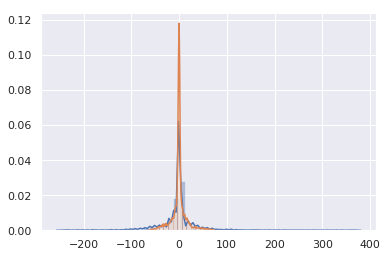

In [78]:
#sns.distplot(x_train[0])
sns.distplot(x_train[-1])
#sns.distplot(x_val[0])
sns.distplot(x_val[-1])

In [79]:
print("Train:", x_train.min(), f"\t {x_train.mean():.2f}", x_train.max())
print("Val:", x_val.min(), f"\t \t {x_val.mean():.2f}", x_val.max())
print("Test:", x_test.min(), f"\t {x_test.mean():.2f}", x_test.max())

Train: -774.71875 	 -0.02 1023.96875
Val: -762.25 	 	 -0.02 1023.96875
Test: -787.03125 	 -0.01 1023.96875


In [80]:
# Reshape data
x_train = x_train.reshape((*x_train.shape, 1))
x_val = x_val.reshape((*x_val.shape, 1))
x_test = x_test.reshape((*x_test.shape, 1))

In [81]:
# Generators
# I am not using generators since currently the dataset fits on RAM

# Load model

In [82]:
"""A much better way to load a custom module since it allows us to change it easierly
    on the fly. Idea from https://zerowithdot.com/colab-workspace/
"""
from os.path import join
from importlib.machinery import SourceFileLoader
wingbeats_model = SourceFileLoader('wingbeats_model', join(BASE_DIR, 'src/models/wingbeats_model.py')).load_module()
model = wingbeats_model.WingbeatsNetModel(dropout=False)
#from src.models.wingbeats_model import WingbeatsNetModel
#model = WingbeatsNetModel(dropout=False)
# load weights?
#f"runs/colab/{COLAB_IDX-1}/model_epoch_90.pt"))
model.summary() 

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_12 (GaussianN (None, 11025, 1)          0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 11023, 16)         64        
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 11021, 16)         784       
_________________________________________________________________
batch_normalization_22 (Batc (None, 11021, 16)         64        
_________________________________________________________________
global_average_pooling1d_7 ( (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 929
Trainable params: 897
Non-trainable params: 32
______________________________________________________

<br>
<br>
<br>
<br>
<br>
<br>

# Start tensorboard

In [22]:
save_path =  BASE_DIR + f"runs/TCC/{TEMPERATURE}/{FORMAT}/{COLAB_IDX}/"

In [23]:
!python3 -m pip install --upgrade grpcio

  Using cached https://files.pythonhosted.org/packages/30/54/c9810421e41ec0bca2228c6f06b1b1189b196b69533cbcac9f71b44727f8/grpcio-1.24.3-cp36-cp36m-manylinux2010_x86_64.whl
  Found existing installation: grpcio 1.11.0
    Uninstalling grpcio-1.11.0:
      Successfully uninstalled grpcio-1.11.0
  Rolling back uninstall of grpcio
  Moving to /home/bcoelho/.local/lib/python3.6/site-packages/grpc/
   from /home/bcoelho/.local/lib/python3.6/site-packages/~rpc
  Moving to /home/bcoelho/.local/lib/python3.6/site-packages/grpcio-1.11.0.dist-info/
   from /home/bcoelho/.local/lib/python3.6/site-packages/~rpcio-1.11.0.dist-info
ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/lib/python3.6/dist-packages/grpcio-1.24.3.dist-info'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'pip install --upgrade pip' command.


In [24]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [25]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 21549), started 0:45:34 ago. (Use '!kill 21549' to kill it.)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# train function

In [83]:
MODEL = "testing"
model_name = f"{MODEL}"

In [84]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping, 
                                        ReduceLROnPlateau, CSVLogger,
                                        TensorBoard)

In [85]:
# Overfit small amount of data
temp = x_train.copy()
temp_y = y_train.copy()

In [86]:
#x_train = x_train[:10]
#_train = y_train[:10]

In [98]:
params["epochs"] = 10
params["batch_size"] = 64

model = wingbeats_model.WingbeatsNetModel(dropout=True, batch_norm=True, 
                                          use_noise=True, blocks=4,
                                          noise_std=1)#lr=0.0001)
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_18 (GaussianN (None, 11025, 1)          0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 11023, 16)         64        
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 11021, 16)         784       
_________________________________________________________________
batch_normalization_27 (Batc (None, 11021, 16)         64        
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 11019, 32)         1568      
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 11017, 32)         3104      
_________________________________________________________________
batch_normalization_28 (Batc (None, 11017, 32)       

In [99]:
"""
from tensorflow.keras.models import Sequential

model2 = Sequential()
wingbeats_model.add_gaussian_noise(model2, 10, x_train.shape[1])
model2.compile(loss="binary_crossentropy")
"""

'\nfrom tensorflow.keras.models import Sequential\n\nmodel2 = Sequential()\nwingbeats_model.add_gaussian_noise(model2, 10, x_train.shape[1])\nmodel2.compile(loss="binary_crossentropy")\n'

In [ ]:
from datetime import datetime

top_weights_path = 'model_' + model_name + '.h5'

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir, write_grads=True,
                                   write_graph=True, write_images=True,
                                   histogram_freq=1)

callbacks_list = [
    #ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1,
    #                save_best_only=True, save_weights_only=True),
    #EarlyStopping(monitor='val_accuracy', patience=6, verbose=1),
    tensorboard_callback]#,
    #ReduceLROnPlateau(monitor = 'val_accuracy', factor=0.1, 
    #                  patience=3, verbose=1),
    #CSVLogger('model_' + model_name + '.log')]

histories = model.fit(x_train, y_train, 
          validation_data=[x_val, y_val],
          callbacks=callbacks_list,
          **params)

#model.load_weights(top_weights_path)
#loss, acc = model.evaluate(x_test, y_test)

#print('loss', loss)
#print('Test accuracy:', acc)

Train on 2972 samples, validate on 743 samples
Epoch 1/10


In [ ]:
def check_grad_proportion(model, x_train, layer_idx=0):
    name = model.get_config()["layers"][layer_idx]["config"]["name"]
    inputs = tf.cast(x_train, tf.float32)

    with tf.GradientTape() as tape:
        preds = model(inputs)

    grads = tape.gradient(preds, model.get_layer(name).trainable_variables)

    weights =  model.get_layer(name).weights
    proportion = grads[0] / weights[0]
    proportion_avg = tf.math.reduce_mean(proportion)
    print(f"Average proportion between grad and weights: {proportion_avg}")
    print(f"Some proportions:")
    print(proportion[:5])
    return grads, weights


In [ ]:
grads, weights = check_grad_proportion(model, x_train)